In [1]:
import pickle
with open('data.pk1', 'rb') as f:
    X, y = pickle.load(f)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [4]:
knn = KNeighborsClassifier()
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

In [5]:
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='f1', n_jobs=-1)
grid_search_knn.fit(X_train, y_train)
best_knn = grid_search_knn.best_estimator_
print("Best parameters for K-Nearest Neighbors:", grid_search_knn.best_params_)

c:\Users\rayry\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters for K-Nearest Neighbors: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}


In [6]:
def evaluate_model(model, X, y, scoring):
    return cross_val_score(model, X, y, cv=5, scoring=scoring)

from sklearn.metrics import make_scorer, recall_score

def specificity_score(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)

specificity = make_scorer(specificity_score)

# Scoring metrics dictionary
scoring_metrics = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'specificity': specificity,  # Custom specificity scorer
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

In [7]:
results = {}

for model_name, model in zip(['KNN'], [best_knn]):
    results[model_name] = {}
    for metric_name, metric in scoring_metrics.items():
        results[model_name][metric_name] = evaluate_model(model, X_train, y_train, metric)

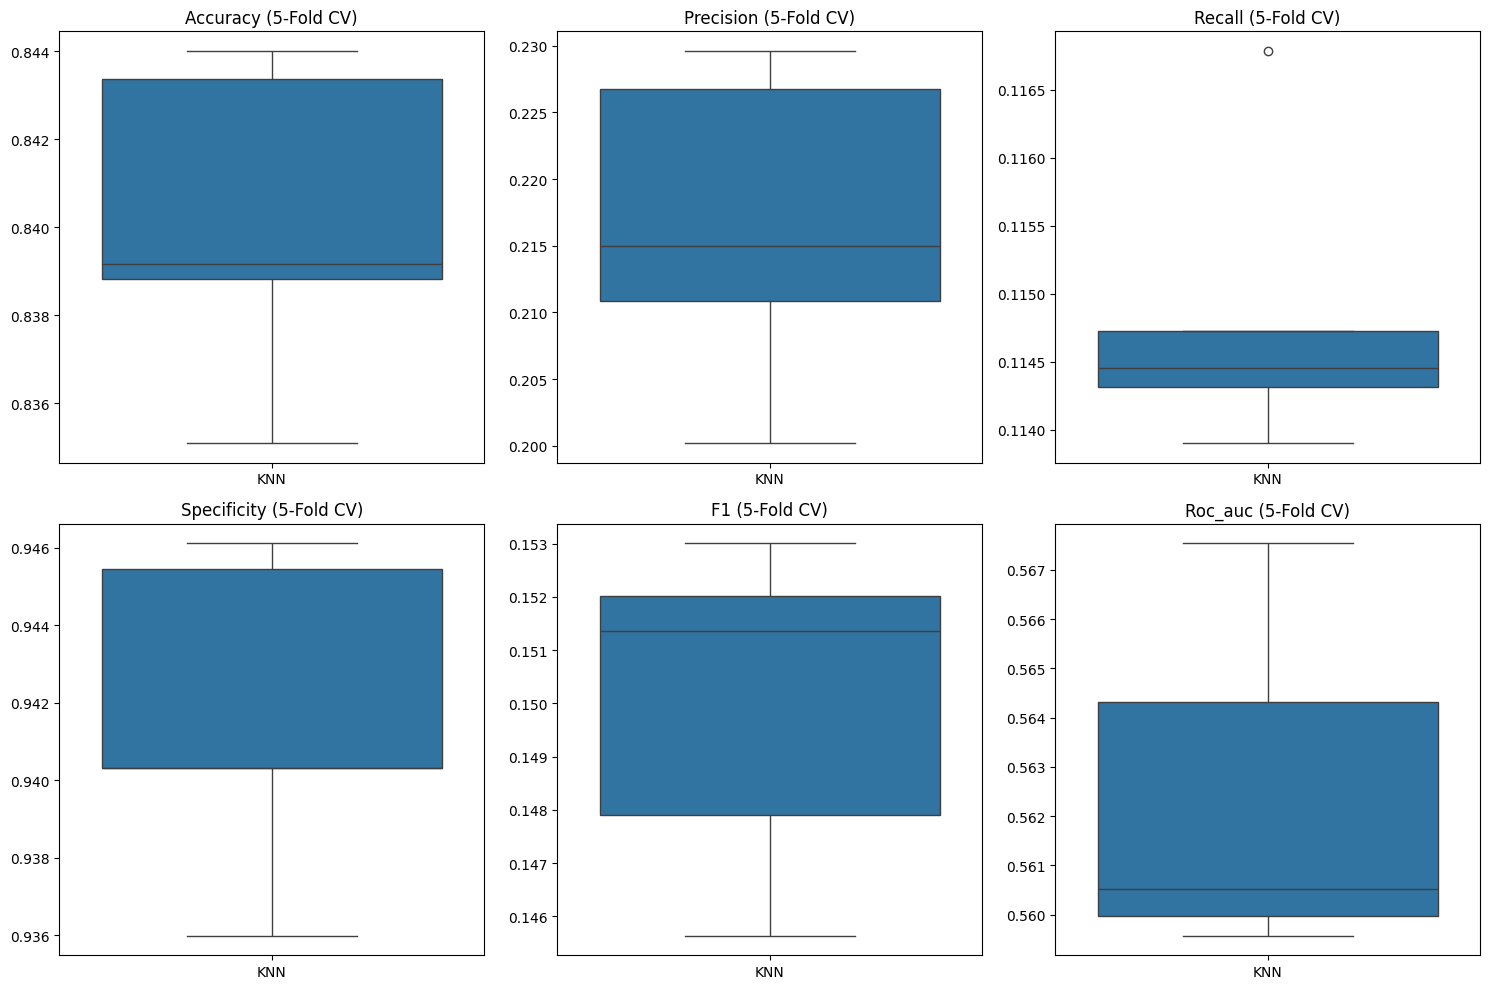

In [8]:
# Create boxplots 
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, metric in enumerate(scoring_metrics):
    data = [results[model][metric] for model in results]
    sns.boxplot(data=data, ax=axes[idx])
    axes[idx].set_title(f'{metric.capitalize()} (5-Fold CV)')
    
    # Set ticks and tick labels
    axes[idx].set_xticks(range(len(results)))
    axes[idx].set_xticklabels(results.keys())
    
plt.tight_layout()

KNN (AUC = 0.53)


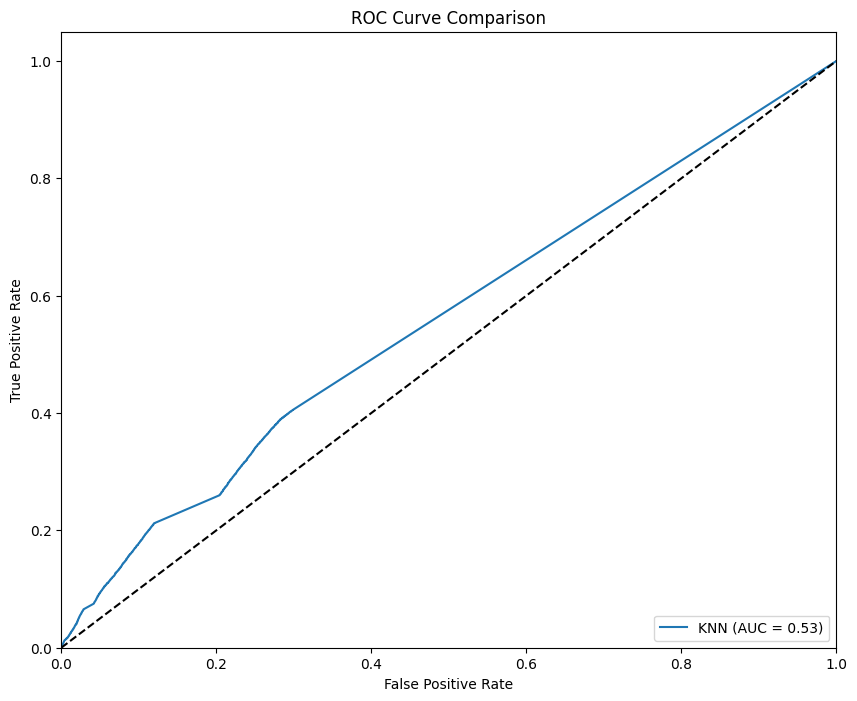

In [12]:
# Evaluate models on the test set and plot ROC curves
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc_curve(models, X_test, y_test):
    plt.figure(figsize=(10, 8))
    for model_name, model in models.items():
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, model.predict(X_test))
        print(f'{model_name} (AUC = {auc:.2f})')
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend(loc="lower right")

# Plot ROC curves for the models
best_models = {'KNN': best_knn}
plot_roc_curve(best_models, X_test, y_test)